In [ ]:
#https://github.com/ancatmara/learnpython2018/blob/master/Homeworks/HW6.md
#открытое сообщество -> выкачать стену + комментарии (возможность 100+ постов и 100+ комментариев)
#посчитайте длину каждого поста и каждого комментария в словах
#график 1: создайте график, описывающий, как длина поста соотносится со средней длиной комментариев
#программа должна смотреть в профиль пользователя, который написал пост или сделал комментарий

#постройте графики зависимости средней длины поста и средней длины комментария от различных социолингвистических параметров:
##график 2: средняя длина поста +
##график 3: средняя длина поста + 
##график 4: средняя длина комментария + город
##график 5: средняя длина комментария + пол

#график 6: частотность для топ 20-30 слов, удалив перед этим стоп-слова с нелемматизированными текстами
#график 7: частотность для топ 20-30 слов с лемматизированными текстами (pymystem pymorphy) 

#графики: заголовок, подписи осей и подписи делений (например, в случае с городами подписями по оси Х будут названия городов)
#картинки с графиками должны быть сохранены отдельными файлами в репозитории

#сдача: облако + ссылка в readme.
#формат корпуса: два файла в plain text, один с оригинальными текстами, другой с лемматизированными. 
#объем корпуса: > 100 постов с комментариями

#https://vk.com/bylaslegedhel

In [ ]:
from requests.exceptions import HTTPError, Timeout
import requests
import json
import os
from datetime import date, datetime
import re

In [ ]:
def clearing_text(text):
    text = re.sub('[.,?!–—"]', ' ', text)
    repl = r'\1'
    text = re.sub('(\s)\s*', repl, text)
    clear_text = text.split(' ')
    return clear_text

In [ ]:
def get_age(birthday):
    today = date.today()
    age = today.year - birthday.year
    if today.month < birthday.month:
        age -= 1
    elif today.month == birthday.month and today.day < birthday.day:
        age -= 1
    return age

def make_csv(status, post_id, poster_id, first_name, last_name,
                 sex, city, bdate, age, education, text):
    length = len(clearing_text(text))
    string = '%s,%s,%s,%s,%s,%s,%s,%s,%s,"%s",%s,"%s"' % (
        status, post_id, poster_id, first_name, last_name,
        sex, city, bdate, age, education, length, text)
    return string

def add_csv(line):
    string = 'status,post_id,owner_id,name,surname,sex,city,' \
             'bdate,age,education,length,text,comments_id\n'
    if not os.path.exists('stats.csv'):
        with open('stats.csv', 'w', encoding='utf-8') as f:
            f.write(string)
    with open('stats.csv', 'a', encoding='utf-8') as f:
        f.write(line)

In [ ]:
def get_poster_info(poster_id, token):
    if poster_id < 0:
        (first_name, last_name, sex, city, bdate,
         age, education) = None, None, None, None, None, None, None
        return first_name, last_name, sex, city, bdate, age, education
    
    params = {'access_token': token, 'v': '5.95', 'user_id': poster_id,
              'fields': 'city,sex,first_name,last_name,bdate,education'}
    try:
        req = requests.get('https://api.vk.com/method/users.get',
                           params=params)
        data = req.text
        req.raise_for_status()
    except HTTPError or Timeout:
        print('Could not get User Info')
        return None
    else:
        data = json.loads(data)
        try:
            items = data['response'][0]
        except KeyError:
            return None
        else:
            first_name = items['first_name']
            last_name = items['last_name']
            sex = items['sex']
    
            if sex == 1:
                sex = 'female'
            elif sex == 2:
                sex = 'male'
            else:
                sex = 'unspecified'

            try:
                city = items['city']['title']
            except KeyError:
                city = None

            try:
                bdate = items['bdate']
            except KeyError:
                bdate = None
                age = None
            else:
                try:
                    day, month, year = bdate.split('.')
                except ValueError:
                    age = None
                else:
                    time_string = day + '/' + month + '/' + year
                    birthday = datetime.strptime(time_string, '%d/%m/%Y')
                    age = get_age(birthday)
 
            try:
                education = items['university_name']
            except KeyError:
                education = None
    return first_name, last_name, sex, city, bdate, age, education

In [ ]:
def get_comment_info(post_id, community_id, token):
    comments = []
    strings = []
    offset = 0
    while True:
        if offset:
            params = {'access_token': token, 'v': '5.95',
                      'owner_id': community_id, 'post_id': post_id,
                      'count': 100, 'offset': offset}
        else:
            params = {'access_token': token, 'v': '5.95',
                      'owner_id': community_id, 'post_id': post_id,
                      'count': 100}
        try:
            req = requests.get('https://api.vk.com/method/wall.getComments',
                               params=params)
            data = req.text
            req.raise_for_status()
        except HTTPError or Timeout:
            print('Could not mine wall for data')
        else:
            status = 'comment'
            data = json.loads(data)
            items = data['response']['items']
            if not items:
                break
            offset += 100
            for item in items:
                try:
                    text = item['text']
                    text = text.replace('\n', ' ')
                except KeyError:
                    text = None
                comment_id = item['id']
                try:
                    poster_id = item['from_id']
                except KeyError:
                    pass
                else:
                    (first_name, last_name, sex, city, bdate,
                     age, education) = get_poster_info(poster_id, token)
                    comments.append(comment_id)
                    string = make_csv(status, post_id, poster_id,
                                          first_name, last_name, sex,
                                          city, bdate, age, education, text)
                    string += ',' + str(comment_id) + '\n'
                    strings.append(string)
    return comments, strings

In [ ]:
def get_poster():
    offset = 0

    while True:
        print('Posts mined', ':', offset)
        token = '780c981c780c981c780c981ccc786525d077' \
                '80c780c981c24abfa09ee63d3dede676550'

        params = {'access_token': token, 'domain': 'bylaslegedhel',
                  'v': '5.95', 'offset': offset, 'count': '100'}
        try:
            req = requests.get('https://api.vk.com/method/wall.get',
                               params=params)
            data = req.text
            req.raise_for_status()
        except HTTPError or Timeout:
            print('Could not mine wall for data')
        else:
            data = json.loads(data)
            items = data['response']['items']
            if not items:
                break
            for item in items:
                post_id = item['id']
                community_id = item['owner_id']
                text = item['text']
                text = text.replace('\n', ' ')
                try:
                    poster_id = item['signer_id']
                except KeyError:
                    poster_id = community_id
                if poster_id != community_id:
                    (first_name, last_name, sex, city, bdate,
                     age, education) = get_poster_info(poster_id, token)
                    status = 'post'
                    comments, strings = get_comment_info(post_id,
                                                         community_id, token)
                    post = make_csv(status, post_id,
                                        poster_id, first_name, last_name,
                                        sex, city, bdate, age, education, text)
                    post += ',' + str(comments) + '\n'
                    add_csv(post)
                    for string in strings:
                        add_csv(string)
            offset += 100
    print('All Clear')


get_poster()

In [ ]:
import csv

text = ''

with open('stats.csv', encoding="utf-8") as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        text += row[11]
        text += '\n'

with open('plain_text.txt', 'w', encoding='utf-8') as f:
    f.write(text)

In [7]:
#row[0] - status
#row[1] - post_id
#row[10] - length

import csv
 
dict1 = {}
with open('stats.csv', encoding="utf-8") as f:
    reader = csv.reader(f, delimiter=',')
    lineCount = 0
    for row in reader:
        if lineCount == 0:
            print(f'Column names are: {", ".join(row)}')
            lineCount += 1
        else:
            p_id = row[1]
            status = row[0]
            if status == 'post':
                if p_id not in dict1:
                    dict1[p_id] = [int(row[10]), []]
            else:
                if p_id in dict1:
                    dict1[p_id][1].append(int(row[10]))

dict2 = {}

for key in dict1:
    comms = dict1[key][1]
    if len(comms) == 0:
        comms_av = 0
    elif len(comms) == 1:
        comms_av = comms[0]
    else:
        comms_av = round(sum(comms) / len(comms), 0)
    post = dict1[key][0]
    dict2[key] = [post, comms_av]

x = []
y = []
for key in dict2:
    x.append(dict2[key][0])
    y.append(dict2[key][1])

Column names are: status, post_id, owner_id, name, surname, sex, city, bdate, age, education, length, text, comments_id


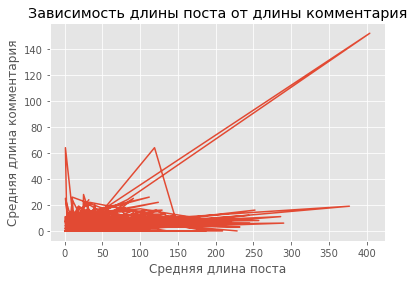

"\na = []\nb = []\nplt.plot(a, b, 'g')\nplt.title('Зависимость длины поста от дня публикации') \nplt.alabel('Средняя длина поста') \nplt.blabel('День публикации') \nplt.show()\n\nc = []\nd = []\nplt.plot(c, d, 'b')\nplt.title('Зависимость длины поста от месяца публикации') \nplt.clabel('Средняя длина поста') \nplt.dlabel('Месяц публикации') \nplt.show()\n"

In [8]:
#график 1: создайте график, описывающий, как длина поста соотносится со средней длиной комментариев
#график 2: средняя длина поста + дня
#график 3: средняя длина поста + месяца

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')

plt.plot(x, y)
plt.title('Зависимость длины поста от длины комментария') 
plt.xlabel('Средняя длина поста') 
plt.ylabel('Средняя длина комментария') 
plt.show()
'''
a = []
b = []
plt.plot(a, b, 'g')
plt.title('Зависимость длины поста от дня публикации') 
plt.alabel('Средняя длина поста') 
plt.blabel('День публикации') 
plt.show()

c = []
d = []
plt.plot(c, d, 'b')
plt.title('Зависимость длины поста от месяца публикации') 
plt.clabel('Средняя длина поста') 
plt.dlabel('Месяц публикации') 
plt.show()
'''

In [12]:
import csv
with open('comms.txt', 'w', encoding='utf-8') as fd:
    fd.write('')
with open('stats.csv', encoding="utf-8") as f:
    reader = csv.reader(f, delimiter=',')
    for row in reader:
        if row[0] == 'comment':
            with open('comms.txt', 'a', encoding='utf-8') as f:
                list_f = [row[5], row[6], row[10]]
                f.write(','.join(list_f))
                f.write('\n')

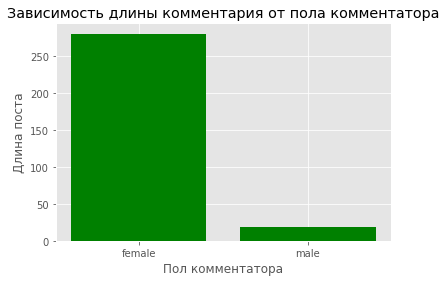

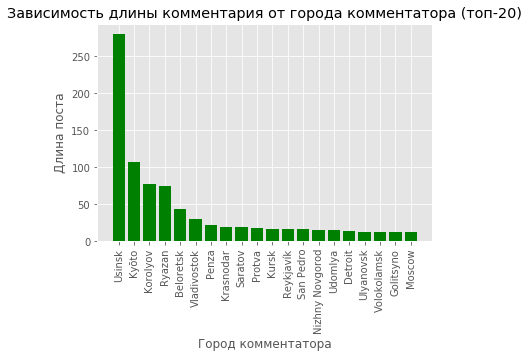

In [23]:
#график 4: средняя длина комментария + пол
#график 5: средняя длина комментария + город

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import csv

e = []
f = []
with open('comms.txt','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        e.append(int(row[2]))
        f.append(row[0])

plt.bar(f, e, color='g')
plt.title('Зависимость длины комментария от пола комментатора')
plt.ylabel('Длина поста')
plt.xlabel('Пол комментатора')
plt.show()

g = []
h = []
dict_cities = {}
with open('comms.txt','r') as csvfile:
    plots = csv.reader(csvfile, delimiter=',')
    for row in plots:
        city = row[1]
        cm_len = int(row[2])
        if city not in dict_cities:
            dict_cities[city] = [cm_len]
        else:
            dict_cities[city].append(cm_len)
for key in dict_cities:
    cmlenlist = dict_cities[key]
    av_cmlen = round(sum(cmlenlist) / len(cmlenlist), 2)
    dict_cities[key] = av_cmlen
for key in sorted(dict_cities, key=dict_cities.get, reverse=True)[:20]:
    g.append(dict_cities[key])
    h.append(key)

plt.bar(h, g, color='g')
plt.title('Зависимость длины комментария от города комментатора (топ-20)')
plt.xticks(range(len(h)), [i for i in h], rotation='vertical')
plt.ylabel('Длина поста')
plt.xlabel('Город комментатора')
plt.show()

In [ ]:
'''
from pymystem3 import Mystem
import pymorphy2

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

m = Mystem()


with open('plain_text.txt', 'r', encoding='utf-8') as f:
    text = f.read()

lemmas = m.lemmatize(text)


ana = m.analyze(text)
'''